In [1]:
import pandas as pd
import re

## Armado de dataset para entrenamiento del modelo

Se usan ventanas de tiempo de 6 meses para agrupar los datos y predecir la baja. 

Training: 
- 1 a 6
- 2 a 7
- 3 a 8
- 4 a 9
- 5 a 10

Optimization
- 6 a 11

Validation
- 7 a 12

Test
- 8 a 13
- 9 a 14

In [2]:
df = pd.read_feather('../../../../data/processed/merged_18_periods(BPICS).feather')

### Detectamos inconsistencias: Del periodo 1 a 3 no hay cargados valores para SITUACION_PP

<h4 style="color:red" > Se soluciona agregando las columnas al dataframe lleno de nulls. REVISAR EL SCRIPT ORIGINAL A FUTURO</h4>

In [3]:
import numpy as np

for col in ['1_SITUACION_PP','2_SITUACION_PP','3_SITUACION_PP']:
    df[col] = np.nan

In [4]:
sini_cols = set([''.join([s for s in col if not s.isdigit()]) for col in df[[col for col in df.columns if re.search(f'\d_TIPO_SINI', col)]].columns])

In [5]:
for col in sini_cols:
    for i in range(1,15):
        if f'{i}{col}' not in df.columns:
            df[f'{i}{col}'] = np.nan

### Script de agrupación de registros de acuerdo a las ventanas temporales. El test está en *1. Test to arrange datasets by time periods*

In [7]:
churn = 4
total_periods = 18

# Buscamos las features que son periódicas
periodic_cols = set([''.join([s for s in col if not s.isdigit()]) for col in df[[col for col in df.columns if re.search(f'\d', col)]].columns])

# Armamos otro dataframe con todas las features que no son temporales
non_periodic_df = df[[col for col in df.columns if not any(char.isdigit() for char in col)]]

# Definimos ventana inicial
w_low = 1
w_top = 6

final_df = pd.DataFrame()

while(w_top <= (total_periods-churn)):
    print(f"----------TIME WINDOW: {w_low} a {w_top}-----------")
    # Armamos todo el nuevo dataset del periodo en grouped_df
    grouped_df = non_periodic_df.copy(deep=True)

    #Seleccionamos las features del periodo
    print("Seleccionando features por periodo...                       ", end="\r", flush=True)
    for pcol in periodic_cols:
        regex_range = "|".join([str(i) for i in range(w_low, w_top+1)])
        regex = f'{pcol}({regex_range})$|^({regex_range}){pcol}'
        columns = [col for col in df.columns if re.search(regex, col)]
        grouped_df[[f"{i}_{pcol}" for i in range(6, 0, -1)]] = df[columns]

    # Buscamos los clientes que no tienen polizas en el periodo analizado
    print("Buscando clientes sin polizas...                       ", end="\r", flush=True)
    grouped_df = grouped_df[grouped_df["hist_polizas"].str.split(" ", expand=True).iloc[:,w_low-1:w_top].astype(float).sum(axis=1) > 0]
    
    # Buscamos las polizas que ya se dieron de baja en el periodo analizado
    print("Buscando clientes que ya se dieron de baja...                  ", end="\r", flush=True)
    grouped_df = grouped_df[~grouped_df["periodo_baja"].between(1, w_top + churn-1)]

    # Preparamos columnas de pólizas por período
    print("Preparando pólizas por períodos...                             ", end="\r", flush=True)
    grouped_df[[f"polizas_{i}" for i in range(6, 0, -1)]] = grouped_df["hist_polizas"].str.split(" ", expand=True).iloc[:,w_low-1:w_top].astype(float)
    
    # Calculamos campos adicionales (Diferencias entre periodos)
    print("Preparando campos adicionales...                             ", end="\r", flush=True)
    for i in range(5, 0, -1):
        grouped_df[f"diff_cant_polizas_{i}"] = grouped_df[f"polizas_{i}"] - grouped_df[f"polizas_{i+1}"]    
        current_int = [col for col in grouped_df.columns if re.search(f'({i})__TIPOINT', col)]
        next_int = [col for col in grouped_df.columns if re.search(f'({i+1})__TIPOINT', col)]
        grouped_df[f"diff_cant_int_{i}"] =  grouped_df[current_int].sum(axis=1) - grouped_df[next_int].sum(axis=1)
        
    # Marcamos aquellos que se dieron de baja a los cuatro meses del periodo analizado
    print("Creando flag de baja...                             ", end="\r", flush=True)
    grouped_df[f"BAJA_{churn}m"] = grouped_df["periodo_baja"] == (w_top + churn)

    # Marcamos un flag para saber la ventana de tiempo que se analiza
    print("Creando flag de periodo...                        ", end="\r", flush=True)
    grouped_df["time_window"] = f"{w_low} a {w_top}"

    # Agregamos el tipo de dataset
    # 2 to test
    # 1 to validation
    # 1 to optimization
    # rest to train
    
    if(w_top > (total_periods-churn-2)):
        grouped_df["dataset"] = 'test'
    elif(w_top > (total_periods-churn-3)):
        grouped_df["dataset"] = 'val'
    elif(w_top > (total_periods-churn-4)):
        grouped_df["dataset"] = 'opt'
    else:
        grouped_df["dataset"] = 'train'
    
    # Agregamos el periodo al datafame final 
    final_df = pd.concat([final_df, grouped_df], ignore_index=True)
    
    del grouped_df
    w_low += 1
    w_top += 1
    print("Next window...                        ")
    
del non_periodic_df
del df
print("Ready!")

----------TIME WINDOW: 1 a 6-----------
Creando flag de baja...onales...                               
Next window...                                    
----------TIME WINDOW: 2 a 7-----------
Creando flag de baja...onales...                               
Next window...                                    
----------TIME WINDOW: 3 a 8-----------
Creando flag de baja...onales...                               
Next window...                                    
----------TIME WINDOW: 4 a 9-----------
Creando flag de baja...onales...                               
Next window...                                    
----------TIME WINDOW: 5 a 10-----------
Creando flag de baja...onales...                               
Next window...                                    
----------TIME WINDOW: 6 a 11-----------
Creando flag de baja...onales...                               
Next window...                                    
----------TIME WINDOW: 7 a 12-----------
Creando flag de baja...onal

In [9]:
final_df

,CIF_ID,hist_polizas,periodo_baja,index,ORIGEN,SEXO,TIPO_PERSONA,CLIENTE,ANO_DE_NACIMIENTO,FECHA_NACIMIENTO,...,diff_cant_int_4,diff_cant_polizas_3,diff_cant_int_3,diff_cant_polizas_2,diff_cant_int_2,diff_cant_polizas_1,diff_cant_int_1,BAJA_4m,time_window,dataset
0,1313.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,-1,0.0,082,M,F,None,1953.0,26/10/1953,...,4.0,0.0,-3.0,0.0,-1.0,0.0,0.0,False,1 a 6,train
1,1482.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,-1,0.0,082,M,F,None,1954.0,11/10/1954,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,1 a 6,train
2,1559.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,-1,0.0,082,M,F,None,1956.0,29/11/1956,...,2.0,0.0,-1.0,0.0,-5.0,0.0,4.0,False,1 a 6,train
3,2994.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,-1,0.0,082,F,F,None,1931.0,18/06/1931,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,False,1 a 6,train
4,4431.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,-1,0.0,082,M,F,None,1964.0,06/11/1964,...,0.0,0.0,3.0,0.0,-2.0,0.0,0.0,False,1 a 6,train
5,5049.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,0.0,082,M,F,None,1953.0,04/10/1953,...,1.0,0.0,1.0,0.0,-1.0,0.0,4.0,False,1 a 6,train
6,5096.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,-1,1.0,082,M,F,None,1963.0,16/04/1963,...,7.0,0.0,9.0,0.0,-15.0,0.0,0.0,False,1 a 6,train
7,5332.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,-1,0.0,082,M,F,None,1965.0,27/03/1965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1 a 6,train
8,5915.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,-1,0.0,082,M,F,None,1947.0,11/01/1947,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,False,1 a 6,train
9,6584.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,-1,0.0,082,F,F,None,1971.0,30/05/1971,...,-2.0,0.0,-1.0,0.0,5.0,0.0,-6.0,False,1 a 6,train


In [12]:
final_df[final_df["CIF_ID"]==16877.0]

,CIF_ID,hist_polizas,periodo_baja,index,ORIGEN,SEXO,TIPO_PERSONA,CLIENTE,ANO_DE_NACIMIENTO,FECHA_NACIMIENTO,...,diff_cant_int_4,diff_cant_polizas_3,diff_cant_int_3,diff_cant_polizas_2,diff_cant_int_2,diff_cant_polizas_1,diff_cant_int_1,BAJA_4m,time_window,dataset
28,16877.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,0.0,082,M,F,None,1963.0,20/01/1963,...,0.0,0.0,-1.0,0.0,1.0,0.0,-1.0,False,1 a 6,train
287376,16877.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,0.0,082,M,F,None,1963.0,20/01/1963,...,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,False,2 a 7,train
575909,16877.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,0.0,082,M,F,None,1963.0,20/01/1963,...,1.0,0.0,-1.0,0.0,0.0,0.0,2.0,False,3 a 8,train
865387,16877.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,0.0,082,M,F,None,1963.0,20/01/1963,...,-1.0,0.0,0.0,0.0,2.0,0.0,0.0,False,4 a 9,train
1154329,16877.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,0.0,082,M,F,None,1963.0,20/01/1963,...,0.0,0.0,2.0,0.0,0.0,0.0,-1.0,False,5 a 10,train
1443853,16877.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,0.0,082,M,F,None,1963.0,20/01/1963,...,2.0,0.0,0.0,0.0,-1.0,0.0,1.0,False,6 a 11,opt
1733300,16877.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,0.0,082,M,F,None,1963.0,20/01/1963,...,0.0,0.0,-1.0,0.0,1.0,0.0,1.0,False,7 a 12,val
2022035,16877.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,0.0,082,M,F,None,1963.0,20/01/1963,...,-1.0,0.0,1.0,0.0,1.0,0.0,-1.0,False,8 a 13,test
2310635,16877.0,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0,18,0.0,082,M,F,None,1963.0,20/01/1963,...,1.0,0.0,1.0,0.0,-1.0,0.0,2.0,True,9 a 14,test


Una vez verificados los datos, eliminamos las columnas que no se van a usar más

In [13]:
final_df = final_df.drop(["CIF_ID","hist_polizas","periodo_baja"], axis=1)

In [14]:
final_df[f"BAJA_{churn}m"].value_counts(normalize=True)

False    0.979248
True     0.020752
Name: BAJA_4m, dtype: float64

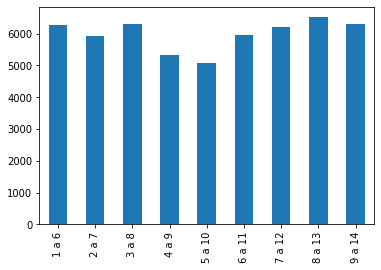

In [17]:
final_df[final_df[f"BAJA_{churn}m"]]["time_window"].value_counts().sort_index().plot.bar()

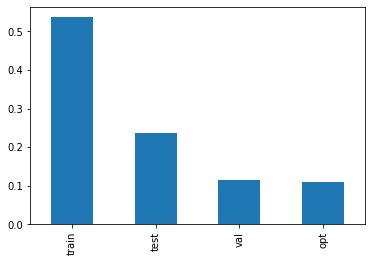

In [18]:
final_df[final_df[f"BAJA_{churn}m"]]["dataset"].value_counts(normalize=True).plot.bar()

## Guardamos los datsets

### Train

In [22]:
final_df[final_df['dataset'] == 'train'].drop(columns='dataset').reset_index(drop=True).to_feather(f"../../../../data/processed/Churn_{churn}_train_set.feather")

### Opt

In [23]:
final_df[final_df['dataset'] == 'opt'].drop(columns='dataset').reset_index(drop=True).to_feather(f"../../../../data/processed/Churn_{churn}_optimization_set.feather")

### Val

In [24]:
final_df[final_df['dataset'] == 'val'].drop(columns='dataset').reset_index(drop=True).to_feather(f"../../../../data/processed/Churn_{churn}_validation_set.feather")

### Test

In [25]:
final_df[final_df['dataset'] == 'test'].drop(columns='dataset').reset_index(drop=True).to_feather(f"../../../../data/processed/Churn_{churn}_test_set.feather")